In [21]:
import sys
import flap

sys.path.append(r"E:\marci main\Fusion\nti-wavelet-tools\python\utility")
sys.path.append(r"C:\marci main\Fusion\nti-wavelet-tools\python\utility")
import convert_dict_to_flap
sys.path.append(r"E:\marci main\Fusion\nti-wavelet-tools\python\core")
sys.path.append(r"C:\marci main\Fusion\nti-wavelet-tools\python\core")
import core

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import cmath
gi=100

In [23]:
#%%script false
path = r"E:\marci main\fusion\inputdata\AUGD_32326_085-095_balltor.sav"
print(path)

obj = core.NWTDataObject()
obj.load_raw_sav(path)
print(obj.raw_data.data.shape)
print(obj.raw_data.coordinates[0].values)
print(obj.raw_data.coordinates[1].values[0])
flap.list_data_objects(obj.raw_data)

E:\marci main\fusion\inputdata\AUGD_32326_085-095_balltor.sav
(9, 200001)
[0.85      0.8500005 0.850001  ... 0.949999  0.9499995 0.95     ]
MHF-B17-02

-----------------------------
<1>(data_source:"" exp_id:"AUGD-32326") data_title:"raw data" shape:[9,200001][no error]
  Data name:"unit", unit:"a.u."
  Coords:
    'Time [s](Dims:1, Shape:[200001]) [<R. symm.>] Val. range:  8.500E-01 -  9.500E-01
    'Channels [a.u.](Dims:0, Shape:[9]) [<R. symm.>] Val:MHF-B17-02, MHF-B31-40, MHA-B31-14, MHA-B31-03, MHA-B31-01, MHA-B31-02, MHA-B31-12, MHH-B31-22, MHA-B31-13
    'Theta [rad](Dims:0, Shape:[9]) [<R. symm.>] Val: 6.164E+00,  6.126E+00,  6.176E+00,  6.171E+00,  6.175E+00,  6.181E+00,  6.169E+00,  6.123E+00,  6.164E+00
    'Phi [rad](Dims:0, Shape:[9]) [<R. symm.>] Val: 1.524E+00,  2.791E+00,  3.590E+00,  4.746E+00,  4.796E+00,  5.184E+00,  5.747E+00,  5.969E+00,  6.791E+00


'\n-----------------------------\n<1>(data_source:"" exp_id:"AUGD-32326") data_title:"raw data" shape:[9,200001][no error]\n  Data name:"unit", unit:"a.u."\n  Coords:\n    \'Time [s](Dims:1, Shape:[200001]) [<R. symm.>] Val. range:  8.500E-01 -  9.500E-01\n    \'Channels [a.u.](Dims:0, Shape:[9]) [<R. symm.>] Val:MHF-B17-02, MHF-B31-40, MHA-B31-14, MHA-B31-03, MHA-B31-01, MHA-B31-02, MHA-B31-12, MHH-B31-22, MHA-B31-13\n    \'Theta [rad](Dims:0, Shape:[9]) [<R. symm.>] Val: 6.164E+00,  6.126E+00,  6.176E+00,  6.171E+00,  6.175E+00,  6.181E+00,  6.169E+00,  6.123E+00,  6.164E+00\n    \'Phi [rad](Dims:0, Shape:[9]) [<R. symm.>] Val: 1.524E+00,  2.791E+00,  3.590E+00,  4.746E+00,  4.796E+00,  5.184E+00,  5.747E+00,  5.969E+00,  6.791E+00'

4000020.0000000014


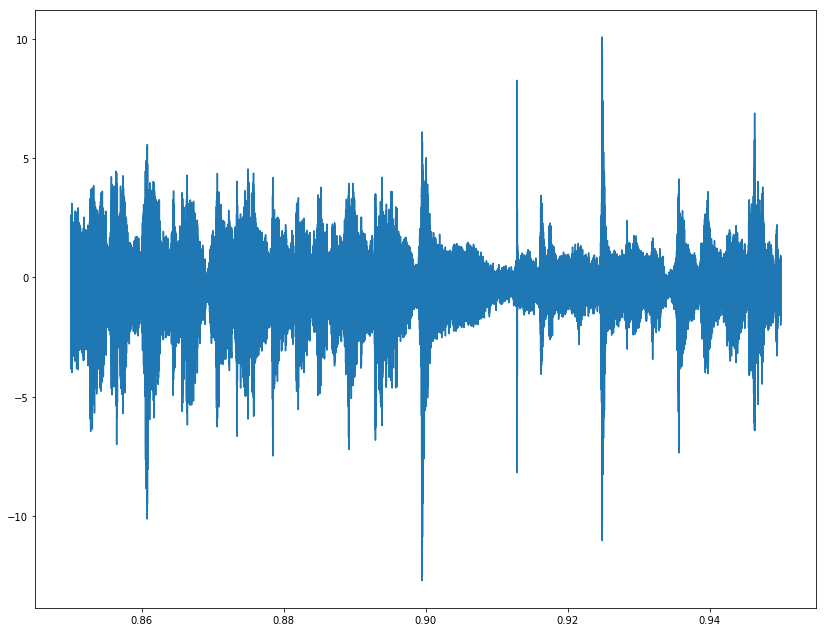

In [24]:
#%%script false
samples = obj.raw_data.data.shape[1]
#f=500
tmin=min(obj.raw_data.coordinates[0].values)
tmax=max(obj.raw_data.coordinates[0].values)
t=tmax-tmin
s_rate=t/samples
nyquist=2/s_rate
print(nyquist)

x = np.linspace(start=tmin,num=samples,stop=tmax)
data = obj.raw_data.data[0]
plt.figure(figsize=(14,11))
plt.plot(x,data)

# testing with generated data

In [25]:
%%script false
gi=gi+1
samples = 39000
f=500
s_rate=4000
t=samples/s_rate
nyquist=s_rate/2

x = np.linspace(start=0,num=samples,stop=t)
data = np.random.normal(0,0.5,samples)+1*np.sin(((f*t*x)%1)*2*np.pi)
plt.figure(figsize=(14,11))
plt.plot(x,data)

Couldn't find program: 'false'


In [26]:
n = int(3*2*samples**0.5)
len_fft = 2*n
fft_jump=80
f_ax, t_ax, stft = scipy.signal.stft(data, nperseg=n, noverlap = n-fft_jump, nfft = len_fft)
t_ax=t_ax/samples*t+tmin
stft=stft*2
print(t_ax)

[0.85      0.85004   0.85008   ... 0.9499195 0.9499595 0.9499995]


In [27]:
#%%script false

ridgei=np.zeros(len(t_ax))
ridge_amp=np.zeros(len(t_ax),dtype=complex)#
stft_abs=np.abs(stft)
viewf_i=len_fft

search_r=10
include_r=35
i_center=int(100000*viewf_i/nyquist) #i=f/wievf_i*nyquist
print(i_center)

search_r=int(search_r)
search_area=np.abs(stft[i_center-include_r:i_center+include_r])
ridgei[0]=np.argmax(search_area[:,0])
for i in range(1,len(t_ax)):
    if i%10000 == 0:
        print(ridgei[i-1])
    ridgei[i]=np.argmax(search_area[:,i])
    #if ridgei[i-1] > search_r+1:
    #    ridgei[i]=np.argmax(search_area[int(ridgei[0])-search_r:int(ridgei[0])+search_r ,i])
    #else: 
    #    ridgei[i]=np.argmax(search_area[0:int(ridgei[0])+search_r ,i])
    ridge_amp[i]=stft[int(ridgei[i]+i_center-include_r),i]
print(np.abs(ridge_amp))
#print(ridgei)
ridgei=ridgei+i_center-include_r

134
[0.         1.09497444 1.2018478  ... 0.34441992 0.30392664 0.26287822]


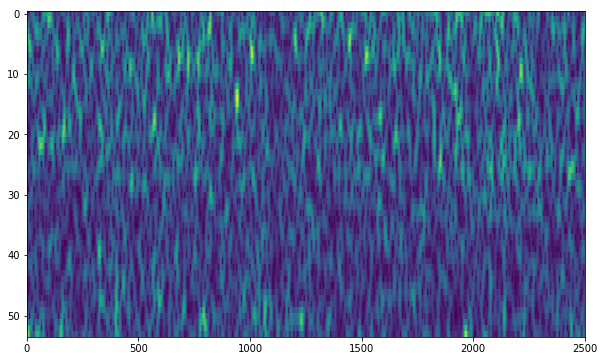

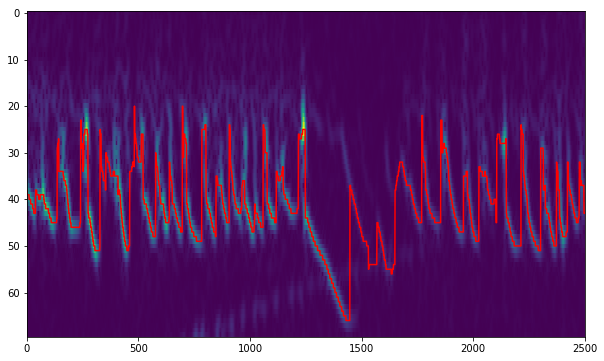

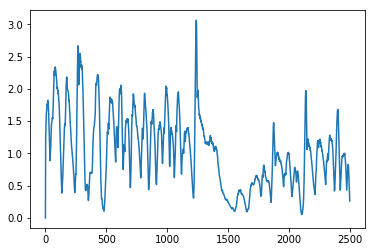

In [43]:
plt.figure(figsize=(10,6))
plt.imshow(np.abs(stft[f_i2:f_i1]),aspect='auto')
plt.show()

plt.figure(figsize=(10,6))
plt.imshow(search_area,aspect='auto')
plt.plot(ridgei-i_center+include_r,'r')#t_ax,
plt.show()

plt.plot(np.abs(ridge_amp))
plt.show()

In [29]:
%%script false

for i in range(int(samples/len_fft)):
    ridgeval=0  #max(z_spy_stft[i][:])
    if (i==0) or (ridge[i-1]==0):
        for j in range(int(ridge_d*(len_fft)/(s_rate-0.9))):
            j2=j+int((ridge_start)*(len_fft)/(s_rate-0.9))
            if ridgeval < z_win_fft_cutted[best_shot][j2][i]:
                ridgeval=z_win_fft_cutted[best_shot][j2][i]
                ridge[i]= j2
    else:
        for j in range(int(ridge_d2*(len_fft)/(s_rate-0.9))):
            j2=int(j+ridge[i-1]-(ridge_d2/2)*(len_fft)/(s_rate-0.9))
            if ridgeval < z_win_fft_cutted[best_shot][j2][i]:
                ridgeval=z_win_fft_cutted[best_shot][j2][i]
                ridge[i]= j2
                #print(j2, z_spy_stft[j2][i])
    #if ridgeval<(maxi):
    #    ridgeval =0
    #    ridge [i]=0
    ridge_h[:,i]=z_win_fft_cutted[:,int(ridge[i]),i]

Couldn't find program: 'false'


In [30]:
f1=60
f2=20
f_i1=int(f1*1000*wievf_i/nyquist)
print(f_i1)
f_i2=int(f2*1000*wievf_i/nyquist)
print(f_i2)
randrange_x=[tmin,tmin,tmax,tmax,tmin]
randrange_y=[f2,f1,f1,f2,f2]

80
26


102795.89228475592
5366 4000020.0000000014


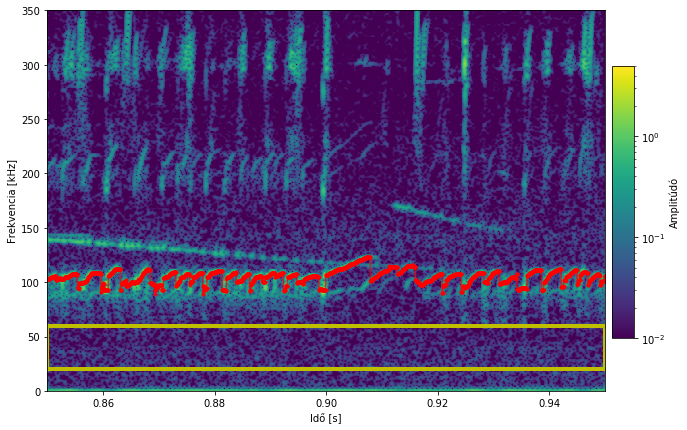

In [44]:
wievd=samples
wievf_i=len_fft
print(np.average(ridgei[:10])/wievf_i*nyquist)
print(len_fft,nyquist)

import matplotlib.colors as colors
colornorm=colors.LogNorm(vmin=0.01, vmax=5)

plt.figure(figsize=(10,7))
plt.imshow(np.abs(stft[:wievf_i,:wievd]),aspect='auto',extent = [tmin,tmax,nyquist/2000,0],norm=colornorm)#,cmap='plasma' ,/len_fft*nyquist,0]
plt.plot(t_ax,ridgei[:wievd]/wievf_i*nyquist/1000,'r.-',alpha=0.7)#/len_fft*nyquist,"r.-"#*wievf*len_fft/s_rate
plt.plot(randrange_x,randrange_y,'y.-',linewidth=4)
#plt.xlim(0,4)
plt.ylim(0,350)
plt.ylabel("Frekvencia [kHz]")
plt.xlabel("Idő [s]")
cax = plt.axes([0.91, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.savefig("ridge")
plt.show()

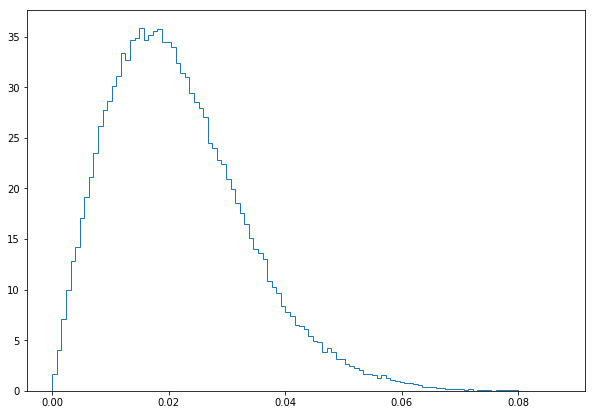

In [40]:
#c = np.abs(chosen).flatten()
#c = chosen.real.flatten()stft[0:15,0:1500]
#print(amplitude[200])

#np.seterr(divide='ignore', invalid='ignore')
amplitude=np.abs(stft[f_i2:f_i1]).flatten()#int(np.average(ridgei))-25  


plt.figure(figsize=(10,7))
n, bins, patches = plt.hist(np.abs(amplitude), bins=111, density = True,facecolor='b',histtype='step')#4.2,4.7,range=(0.7,1.3
#plt.xlim(4.2,4.7)
plt.savefig("hist")
plt.show()
dist_x=bins[:-1]/2+bins[1:]/2

In [33]:
locg, stdg = scipy.stats.norm.fit(np.abs(amplitude))#,loc=0.5
print("normfit")
shape_r,loc_r,scale_r=scipy.stats.rice.fit(np.abs(amplitude))#,floc=0

normfit


In [34]:
print(locg,stdg)
print(shape_r,loc_r,scale_r)
print("Amplitúdó Rice eloszlással: ",shape_r*scale_r+loc_r, ",  Var: ", np.sqrt(scale_r))
print("Amplitúdó Gauss eloszlással: ",locg, ",  Var: ", np.sqrt(stdg))

0.021635853 0.011764041
0.07517046835005635 -0.00015924654039477107 0.017488866446063206
Amplitúdó Rice eloszlással:  0.0011553997412673857 ,  Var:  0.1322454779796391
Amplitúdó Gauss eloszlással:  0.021635853 ,  Var:  0.10846216


Zaj:
0.05388128799561231 0.028243855123431433
0.0012425123713100464 0 0.04301689031333428
Amplitúdó Rice eloszlással:  5.3449018389605135e-05
Amplitúdó Gauss eloszlással:  0.05388128799561231 ,  Var:  0.16805908224023905

Jel:
0.9938795615182778 0.049566682596736786
20.013851182443467 0 0.04959763968882898
Amplitúdó Rice eloszlással:  0.9926397797326749
Amplitúdó Gauss eloszlással:  0.9938795615182778 ,  Var:  0.22263576216937114

59.749606467598845
1.0449528877166705
0.017488866446063206
0.0


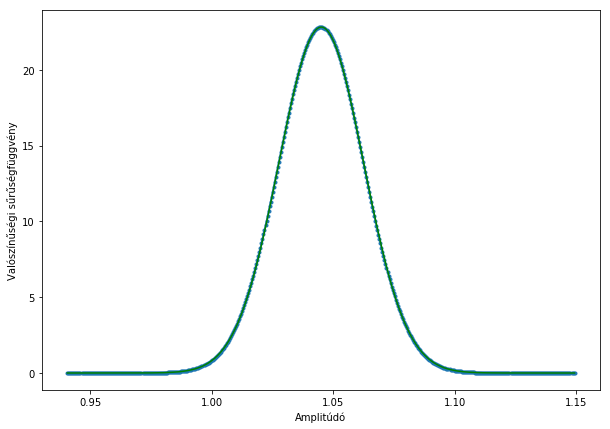

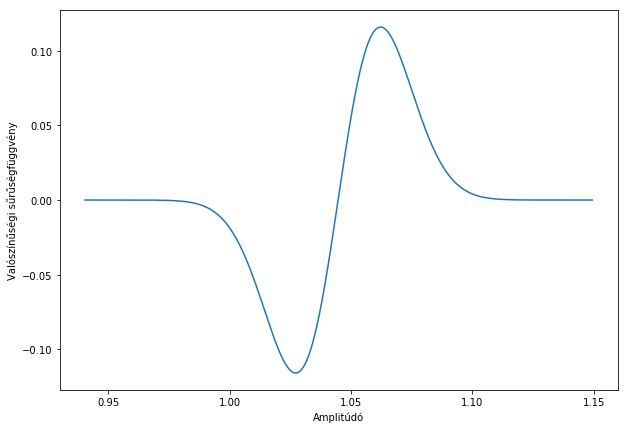

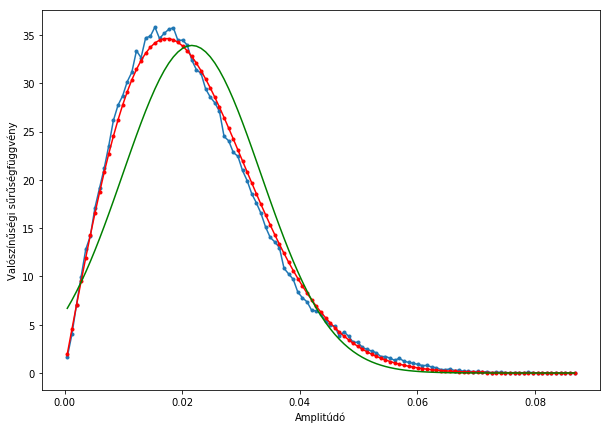

In [41]:
s2=scale_r#0.04301689031333428
v2=np.mean(np.abs(ridge_amp))
loc2=loc_r
print(v2/s2)
print(v2)
print(s2)
print(np.min(np.abs(ridge_amp)))

plt.figure(figsize=(10,7))
#plt.plot(dist_x,n,'.-')
x2=np.linspace(start=v2*0.9,num=500,stop=v2*1.1)
#plt.plot(dist_x,scipy.stats.rice.pdf(dist_x,shape_r,loc_r,scale_r),'r.-') 
plt.plot(x2,scipy.stats.rice.pdf(x2,v2/s2,loc2,s2),'.-') 
plt.plot(x2,scipy.stats.norm.pdf(x2,loc=v2-loc2,scale=s2),'g-') 
#plt.xlim(0.7,1.3)
#tmp_str=+str(gi)
plt.ylabel("Valószínűségi sűrűségfüggvény")
plt.xlabel("Amplitúdó")
plt.savefig("compare"+str(gi))
plt.show()

plt.figure(figsize=(10,7))
#plt.plot(dist_x,n,'.-')
x2=np.linspace(start=v2*0.9,num=500,stop=v2*1.1)
#plt.plot(dist_x,scipy.stats.rice.pdf(dist_x,shape_r,loc_r,scale_r),'r.-') 
plt.plot(x2,(scipy.stats.rice.pdf(x2,v2/s2,loc2,s2)-scipy.stats.norm.pdf(x2,loc=v2+loc2,scale=s2)),'-') 
plt.ylabel("Valószínűségi sűrűségfüggvény")
plt.xlabel("Amplitúdó")
plt.savefig("diff"+str(gi))
plt.show()

plt.figure(figsize=(10,7))
plt.plot(dist_x,n,'.-')
plt.plot(dist_x,scipy.stats.rice.pdf(dist_x,shape_r,loc_r,scale_r),'r.-') 
#plt.plot(dist_x,scipy.stats.rice.pdf(dist_x,v2/s2,0,s2),'-') 
plt.plot(dist_x,scipy.stats.norm.pdf(dist_x,loc=locg,scale=stdg),'g-') 
#plt.xlim(0.7,1.3)
#tmp_str=
plt.ylabel("Valószínűségi sűrűségfüggvény")
plt.xlabel("Amplitúdó")
plt.savefig("norm_compare"+str(gi))
plt.show()

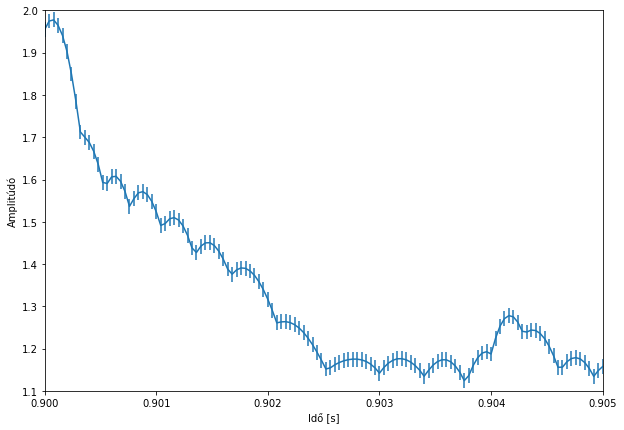

In [52]:
plt.figure(figsize=(10,7))
#plt.plot(t_ax,np.abs(ridge_amp),'.-')
plt.errorbar(t_ax,np.abs(ridge_amp),s2)
plt.plot([t_ax[0],t_ax[-1]],[3*s2,3*s2])
#plt.plot(t_ax,np.abs(ridge_amp)+s2,'b-')
#plt.plot(t_ax,np.abs(ridge_amp)-s2,'b-')
plt.ylabel("Amplitúdó")
plt.xlabel("Idő [s]")
plt.xlim(0.9,0.905)
plt.ylim(1.1,2)
#plt.xlim(0.85,0.95)
#plt.ylim(0,3.2)
plt.savefig("ampz"+str(gi))
plt.show()

In [55]:
len_amp = len(np.abs(ridge_amp))
avg_diff=0
for i in range(len_amp-1):
    avg_diff = avg_diff+np.abs(np.abs(ridge_amp[i])-np.abs(ridge_amp[i+1]))/len_amp
print(avg_diff)
print(s2)
print(avg_diff/s2)

0.03100405795752623
0.017488866446063206
1.7727883081013138


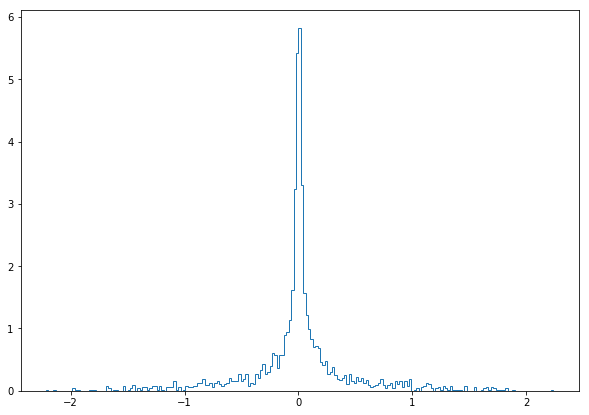

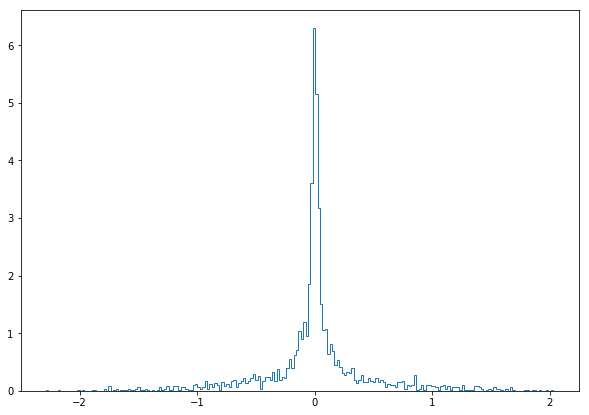

In [42]:
amp_im = stft[int(np.average(ridgei))].imag.flatten()
amp_re = stft[int(np.average(ridgei))].real.flatten()

plt.figure(figsize=(10,7))
n, bins, patches = plt.hist(amp_re, bins=211, density = True,facecolor='b',histtype='step')#4.2,4.7,range=(0.7,1.3)
#plt.xlim(4.2,4.7)
plt.savefig("hist_re")
plt.show()
dist_x=bins[:-1]

plt.figure(figsize=(10,7))
n, bins, patches = plt.hist(amp_im, bins=211, density = True,facecolor='b',histtype='step')#4.2,4.7,range=(0.7,1.3)
#plt.xlim(4.2,4.7)
plt.show()
dist_x=bins[:-1]

loc_im, std_im = scipy.stats.norm.fit(amplitude.imag)
loc_re, std_re = scipy.stats.norm.fit(amplitude.real)

In [38]:
%%script false
max = np.max(np.abs(stft))
plt.figure(figsize=(14,11))
plt.pcolormesh(t_ax, f_ax, np.abs(stft), vmin=0, vmax=max, shading='plasma')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
cax = plt.axes([0.91, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.savefig("test_stft_abs")
plt.show()

plt.figure(figsize=(14,11))
plt.pcolormesh(t_ax, f_ax, stft.real, vmin=-max, vmax=max, shading='plasma')
plt.title('STFT Real')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
cax = plt.axes([0.91, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.savefig("test_stft_real")
plt.show()

plt.figure(figsize=(14,11))
plt.pcolormesh(t_ax, f_ax, stft.imag, vmin=-max, vmax=max, shading='plasma')
plt.title('STFT Imag')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
cax = plt.axes([0.91, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.savefig("test_stft_imag")
plt.show()

plt.figure(figsize=(14,11))
plt.pcolormesh(t_ax, f_ax, np.angle(stft), vmin=-6, vmax=6, shading='plasma')
plt.title('STFT Phase')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
cax = plt.axes([0.91, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.savefig("test_stft_phase")
plt.show()

Couldn't find program: 'false'


In [39]:
%%script false
shape_h=25
scale_h=25
loc_h=18
diff = np.zeros((shape_h,scale_h,loc_h))
shape = np.linspace(0,8,shape_h)
scale = np.linspace(0.04,0.10,scale_h)
loc = np.linspace(0.0,0.6,loc_h)
for i in range(shape_h):
    for j in range(scale_h):
        for k in range(loc_h):
            diff[i,j,k] = np.average((scipy.stats.rice.pdf(dist_x,shape[i],loc[k],scale[j])-n)**2)
    if i%2 == 0:
        print(i)
#print(divmod(diff.argmin(), diff.shape[1]))

#mini = np.min(diff)
x1,y1,z1=np.unravel_index(diff.argmin(), diff.shape)
print(x1,y1,z1)
print(shape[x1],scale[y1],loc[z1])

plt.figure(figsize=(14,11))
plt.imshow(diff[:,:,z1],aspect='auto')
plt.plot(y1,x1,'ro')
plt.ylabel("shape")
plt.xlabel("scale")
plt.show()

Couldn't find program: 'false'
